In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# 高斯混合模型（GMM）为什么会出现：k-means算法的缺陷

In [2]:
# 生成数据
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, 
                       centers=4,
                       cluster_std=0.60,
                       random_state=0)
X = X[:, ::-1] # 交换是为了方便画图

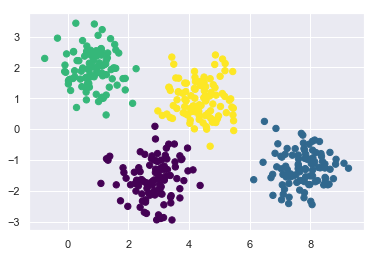

In [3]:
# 用k-means标签画出数据
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], 
            c=labels, # 颜色
            s=40, # 标记大小
            cmap='viridis')

In [4]:
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    # 画出输入数据
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1],
               c=labels, # 颜色
               s=40, # 标记大小
               cmap='viridis', 
               zorder=2)
    
    # 画出k-means模型的表示
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, # 圆的圆心 
                                r, # 半径
                                fc='#CCCCCC', 
                                lw=3, # 线宽 
                                alpha=0.5, # 透明度
                                zorder=1))

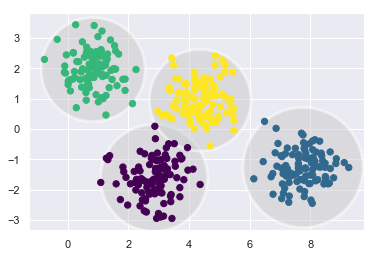

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

k-means要求这些簇的模型必须是圆形：k-means算法没有内置的方法来实现椭圆形的簇

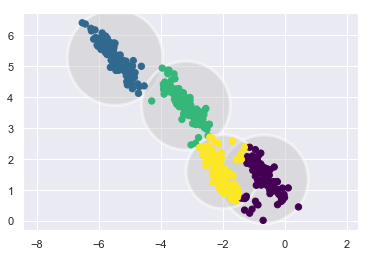

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

# 一般化E-M：高斯混合模型

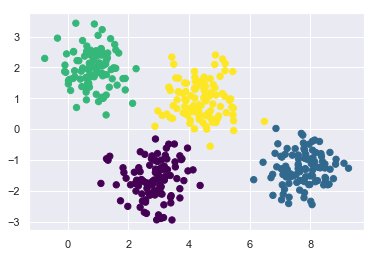

In [7]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1],
            c=labels,
            s=40,
            cmap='viridis')

In [8]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.469 0.    0.531]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


In [9]:
probs[:5].max(1)

array([0.53076163, 1.        , 1.        , 0.9999084 , 1.        ])

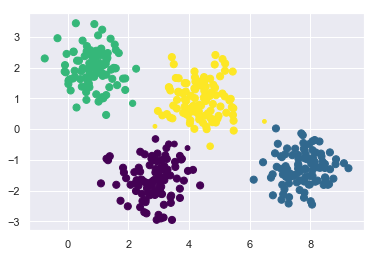

In [10]:
# 平方强调差异
size = 50 * probs.max(1) ** 2 # 按行求最大值
plt.scatter(X[:, 0], X[:, 1],
            c=labels, # 颜色
            cmap='viridis',
            s=size) # 根据所属簇的概率大小来标记

高斯混合模型的步骤：
1. 选择初始簇的中心位置和形状
2. 重复直至收敛
    1. **期望步骤**（E-step）：为每个点找到对应每个簇的概率作为权重
    2. **最大化步骤**（M-step）：更新每个簇的位置，将其标准化，并且基于所有数据点的权重来确定形状

In [11]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """用给定的位置和协方差画一个椭圆"""
    ax = ax or plt.gca()
    
    # 将协方差转换成主轴
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    # 画出椭圆
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, 
                             nsig * width, nsig * height, 
                             angle, 
                             **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], 
                   c=labels, 
                   s=40,
                   cmap='viridis',
                   zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   s=40,
                   zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

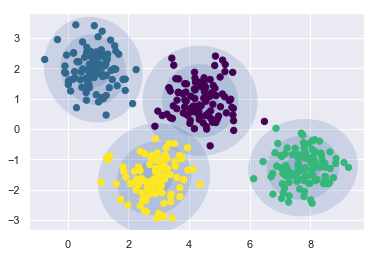

In [12]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

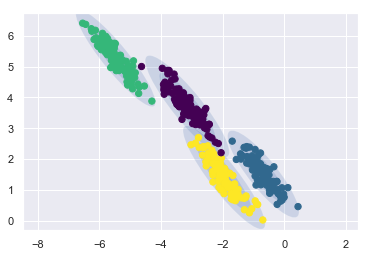

In [13]:
gmm = GaussianMixture(n_components=4, 
                      covariance_type='full', 
                      random_state=42)
plot_gmm(gmm, X_stretched)

# 将GMM用作密度估计

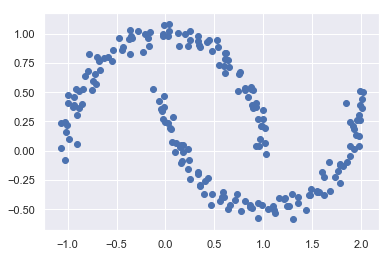

In [14]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, # 200个数据点
                          noise=0.05, # 噪声
                          random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

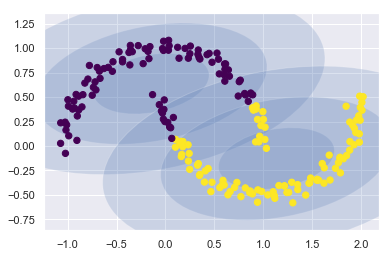

In [15]:
gmm2 = GaussianMixture(n_components=2, 
                       covariance_type='full', 
                       random_state=0)
plot_gmm(gmm2, Xmoon)

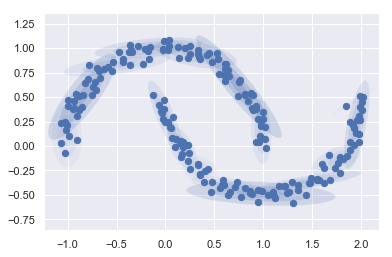

In [16]:
gmm16 = GaussianMixture(n_components=16,
                        covariance_type='full',
                        random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

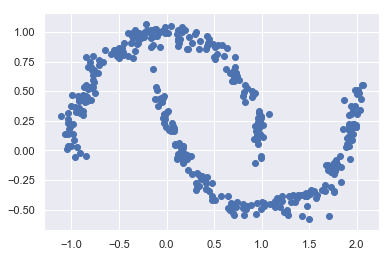

In [17]:
Xnew, ynew = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1])

Text(0.5, 0, 'n_components')

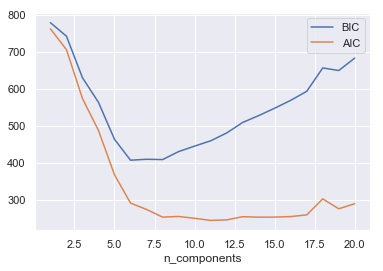

In [18]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon) for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

# 示例：用GMM生成新的数据

In [19]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

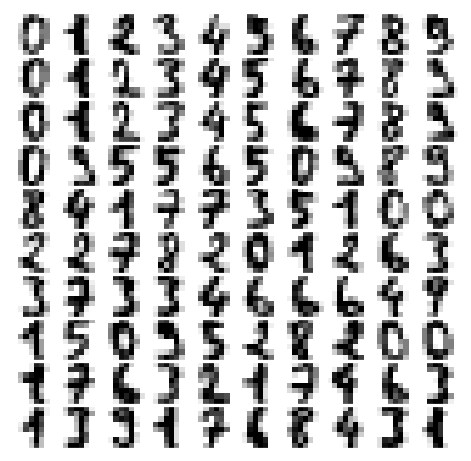

In [20]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05) # 调整子图之间间距
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)

plot_digits(digits.data)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

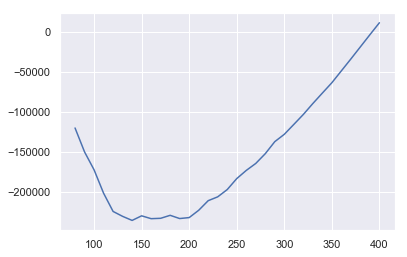

In [22]:
n_components = np.arange(80, 410, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics)

In [23]:
gmm = GaussianMixture(200, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [24]:
X_data_new, y_data_new = gmm.sample(100)
X_data_new.shape

(100, 41)

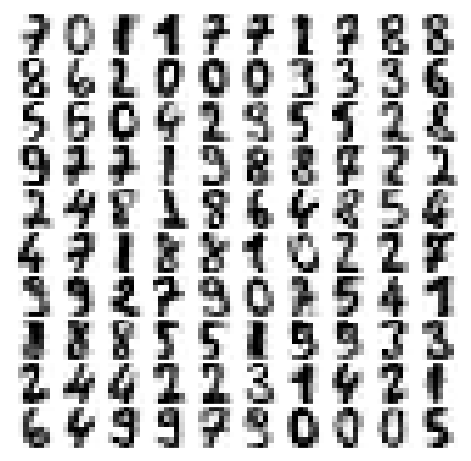

In [25]:
digits_new = pca.inverse_transform(X_data_new)
plot_digits(digits_new)